In [1417]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, KernelPCA
import seaborn as sns
sns.set()
rcParams['figure.figsize']=(15, 8)
plt.style.use('ggplot')

In [1498]:
EVENTS_FILE = "data/football-events/events.csv"
GAME_INFO_FILE = "data/football-events/ginf.csv"
TEST_SET_RATIO = 0.1

In [1499]:
game_info_df = pd.read_csv(GAME_INFO_FILE)
game_info_df.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [1500]:
# Show leagues available
leagues = game_info_df['league'].unique()
seasons = game_info_df['season'].unique()
print("Leagues:", leagues)
print("Seasons:", seasons)

Leagues: ['D1' 'F1' 'E0' 'SP1' 'I1']
Seasons: [2012 2013 2014 2015 2016 2017]


In [1501]:
# Filter games
leagues_mask = game_info_df['league'] == 'F1'
seasons_mask = game_info_df['season'] > 2011
game_info_df = game_info_df[leagues_mask & seasons_mask]
print(game_info_df.shape)
game_info_df.head()

(2107, 18)


,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
6,M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
7,QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
8,UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN


In [1502]:
home_teams = game_info_df['ht'].unique()
away_teams = game_info_df['at'].unique()
print("Nb teams home: %d" % home_teams.size)
print("Nb teams away: %d" % away_teams.size)

Nb teams home: 30
Nb teams away: 30


In [1503]:
to_remove = []
for i,team in enumerate(away_teams):
    if not team in home_teams:
        print(i, team)
        to_remove.append(i)

In [1504]:
away_teams = np.delete(away_teams, to_remove)
print("Nb teams home: %d" % home_teams.size)
print("Nb teams away: %d" % away_teams.size)

Nb teams home: 30
Nb teams away: 30


In [1505]:
#home_teams = np.sort(home_teams)
#away_teams = np.sort(away_teams)
away_teams = home_teams
assert(np.array_equal(home_teams, away_teams))

teams_to_idx = {}
for i, team in enumerate(home_teams):
    teams_to_idx[team] = i

In [1506]:
X = np.identity(home_teams.size)
counts = np.zeros((home_teams.size, away_teams.size))
print(X.shape)
print(counts.shape)

(30, 30)
(30, 30)


In [1507]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [1508]:
for index, row in game_info_df.iterrows():
    home_team = row['ht']
    away_team = row['at']
    home_score = row['fthg']
    away_score = row['ftag']
    prob_home_team_win = sigmoid(home_score - away_score)
    if not home_team in teams_to_idx or not away_team in teams_to_idx:
        continue
        
    home_idx = teams_to_idx[home_team]
    away_idx = teams_to_idx[away_team]
    counts[home_idx, away_idx] += 1
    X[home_idx, away_idx] += prob_home_team_win

In [1509]:
np.seterr(divide='ignore')
X = np.divide(X, counts)
np.seterr(divide='raise')
X[X == np.inf] = np.nan

/Users/valentin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [1510]:
# Sort by sum of col -> for away_teams
teams_with_sum_col = []
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 1.0
temp_X
for i in range(temp_X.shape[1]):
    teams_with_sum_col.append((away_teams[i], np.sum(temp_X[:, i])))

teams_with_sum_col.sort(key=lambda pair: -pair[1])
away_teams = list(map(lambda pair: pair[0], teams_with_sum_col))

# Sort by sum of row -> for home_teams
teams_with_sum_row = []
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 0.0
for i in range(temp_X.shape[0]):
    teams_with_sum_row.append((home_teams[i], np.sum(temp_X[i, :])))
    
teams_with_sum_row.sort(key=lambda pair: -pair[1])
home_teams = list(map(lambda pair: pair[0], teams_with_sum_row))

In [1511]:
# Sort X by rows' sum, then by columns' sum
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 0.0
X = X[np.argsort(-temp_X.sum(axis=1))]

temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 1.0
X = X[:, np.argsort(-temp_X.sum(axis=0))]

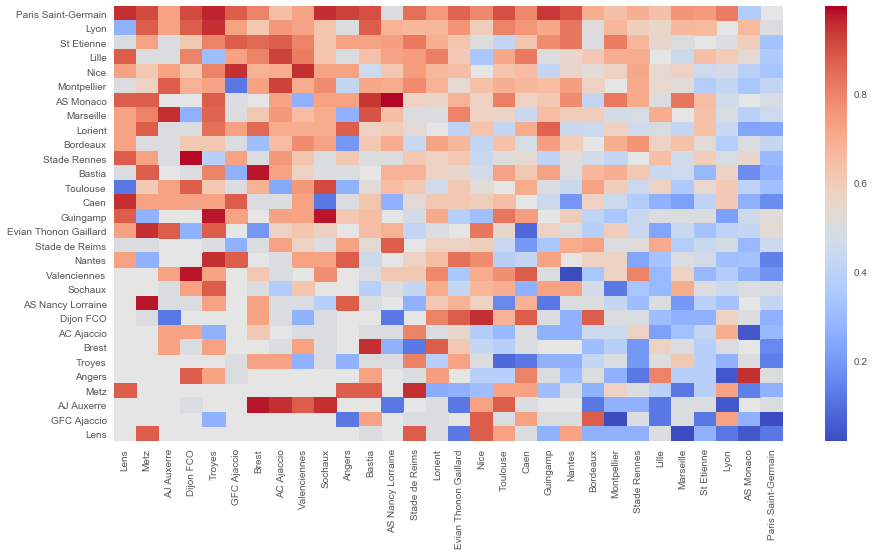

In [1512]:
#X[X == 0] = 0.5
#plt.imshow(X, cmap='hot', interpolation='nearest')
sns.heatmap(X, xticklabels=away_teams, yticklabels=home_teams, cmap="coolwarm")

In [1513]:
mean = np.nanmean(X)
print("Home advantage:", mean)

# What to do with NaNs??
X[np.isnan(X)] = mean

Home advantage: 0.56412171329


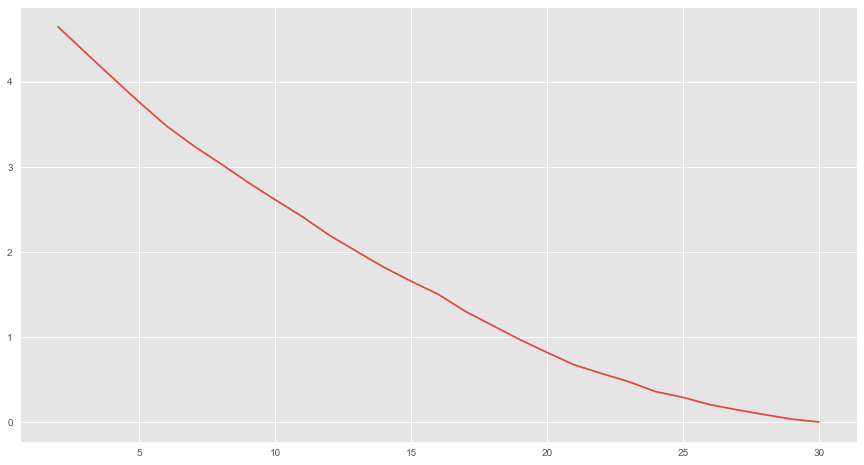

In [1514]:
errors = []
max_k = len(away_teams)
for nb_comp in np.arange(max_k, 1, -1):
    model = NMF(n_components=nb_comp, init='random', random_state=0, max_iter=500)
    W = model.fit_transform(X)
    H = model.components_
    errors.append(model.reconstruction_err_)
    
k = max_k
model = NMF(n_components=k, init='random', random_state=0, max_iter=500)
W = model.fit_transform(X)
H = model.components_

plt.plot(np.arange(2, max_k+1), errors[::-1])

In [1515]:
model

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=500, n_components=30, random_state=0, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [1516]:
W.shape

(30, 30)

In [1517]:
model.reconstruction_err_

0.0051797985429724641

## t-SNE

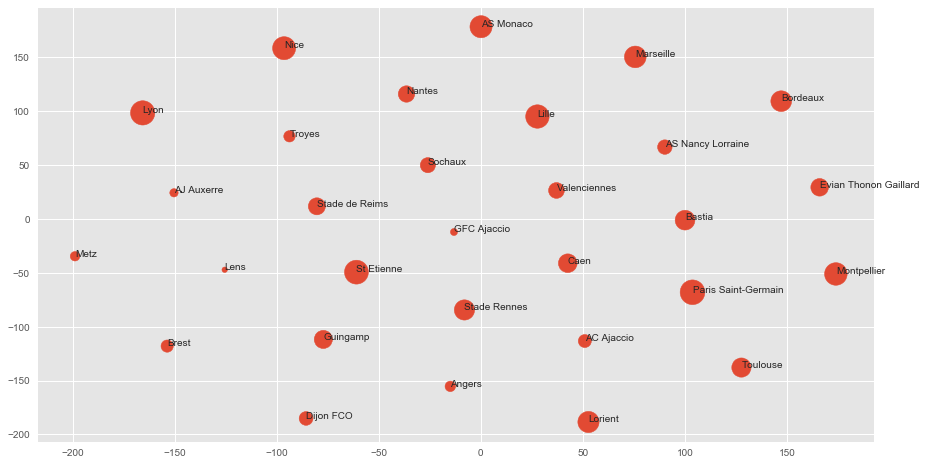

In [1518]:
# Latent variables for home_teams
W_embedded = TSNE(n_components=2).fit_transform(W)
x = W_embedded[:,0]
y = W_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

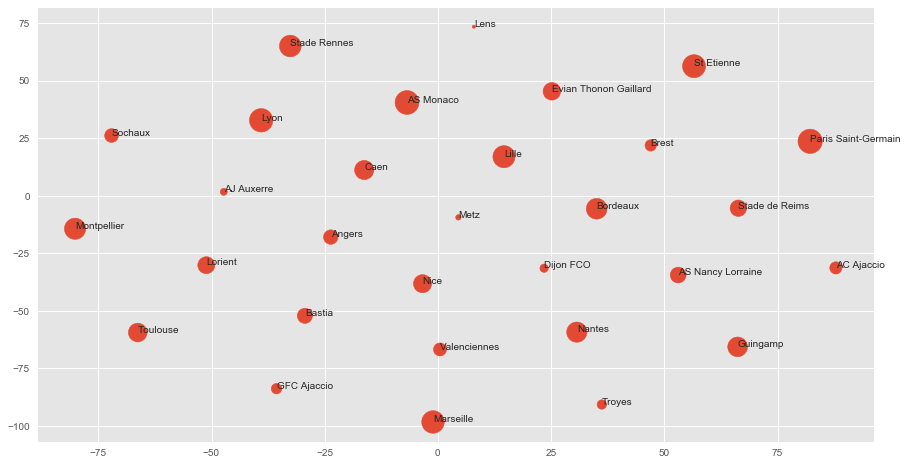

In [1519]:
# Latent variables for away_teams
H_embedded = TSNE(n_components=2).fit_transform(H.T)
x = H_embedded[:,0]
y = H_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(home_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))

## PCA

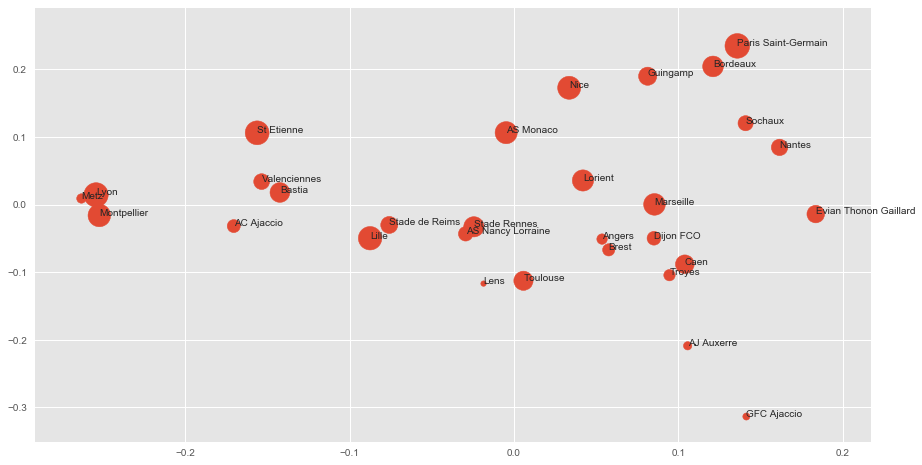

In [1520]:
# Latent variables for home_teams
pca_W = KernelPCA(n_components=2, kernel='rbf')
new_W = pca_W.fit_transform(W)
#print(pca_W.explained_variance_ratio_)
x = new_W[:,0]
y = new_W[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

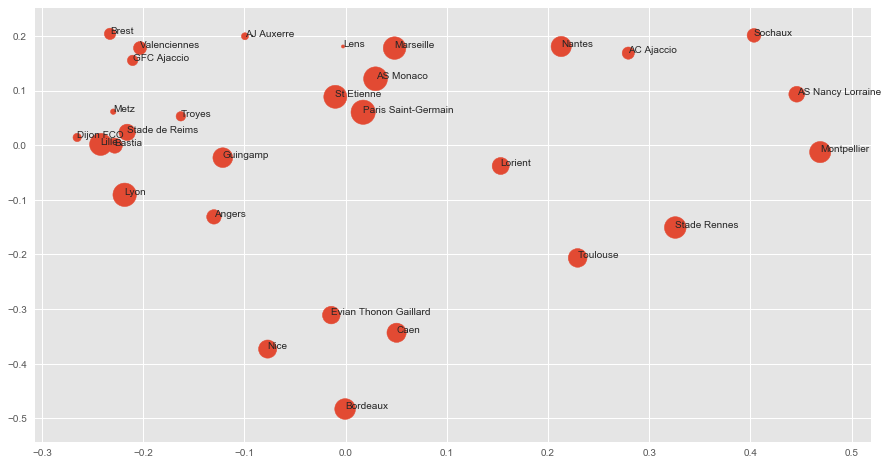

In [1521]:
# Latent variables for away_teams
pca_H = KernelPCA(n_components=2, kernel='rbf')
new_H = pca_H.fit_transform(H.T)
#print(pca_H.explained_variance_ratio_)
x = new_H[:,0]
y = new_H[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(away_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))

### Use latent features to predict output of games

In [1522]:
dataset_size = game_info_df.shape[0]
test_set_size = int(dataset_size * TEST_SET_RATIO)
print("Dataset size:", dataset_size)
print("Test set size:", test_set_size)

Dataset size: 2107
Test set size: 210


In [1523]:
home_teams_to_latent = {}
for i, team_name in enumerate(home_teams):
    home_teams_to_latent[team_name] = W[i]

away_teams_to_latent = {}
for i, team_name in enumerate(away_teams):
    away_teams_to_latent[team_name] = H[:,i]


In [1524]:
use_home_and_away_features = False

games = []
for idx, row in game_info_df.iterrows():
    home_team = row['ht']
    away_team = row['at']
    home_goals = row['fthg']
    away_goals = row['ftag']
    id_odsp = row['id_odsp']
    season = row['season']
    prob_home_team_win = sigmoid(home_goals - away_goals)
    to_append = []
    to_append.append([prob_home_team_win, id_odsp])
    if not home_team in home_teams_to_latent or not home_team in away_teams_to_latent or not away_team in home_teams_to_latent or not away_team in away_teams_to_latent:
        continue
    to_append.append(home_teams_to_latent[home_team])
    if use_home_and_away_features:
        to_append.append(away_teams_to_latent[home_team])
        to_append.append(home_teams_to_latent[away_team])
    to_append.append(away_teams_to_latent[away_team])
    # Flatten list
    to_append = [item for sublist in to_append for item in sublist]
    games.append(to_append)

# Create column names
labels = ['y', 'id_odsp']
for i in range(1, k+1):
    labels.append('home_team_home_latent_%d' % i)
    
if use_home_and_away_features:
    for i in range(1, k+1):
        labels.append('home_team_away_latent_%d' % i)
    for i in range(1, k+1):
        labels.append('away_team_home_latent_%d' % i)
        
for i in range(1, k+1):
    labels.append('away_team_away_latent_%d' % i)
    
games_latent_df = pd.DataFrame.from_records(games, columns=labels)
print(games_latent_df.shape)
games_latent_df.head()

(2107, 62)


,y,id_odsp,home_team_home_latent_1,home_team_home_latent_2,home_team_home_latent_3,home_team_home_latent_4,home_team_home_latent_5,home_team_home_latent_6,home_team_home_latent_7,home_team_home_latent_8,...,away_team_away_latent_21,away_team_away_latent_22,away_team_away_latent_23,away_team_away_latent_24,away_team_away_latent_25,away_team_away_latent_26,away_team_away_latent_27,away_team_away_latent_28,away_team_away_latent_29,away_team_away_latent_30
0,0.268941,CzPV312a/,1.379726,0.090443,0.050636,0.453174,0.052158,0.069478,0.077074,0.468201,...,0.000000,0.149711,0.041510,0.043864,0.464685,0.301492,0.000191,0.006939,0.633890,0.001798
1,0.731059,GUOdmtII/,0.498634,0.298510,0.000000,0.026156,0.000000,0.647482,0.000000,0.004491,...,0.000000,0.001072,0.123613,0.000901,0.011379,0.090252,0.034110,0.153293,0.000000,0.000000
2,0.500000,M7PhlM2C/,0.108407,0.000000,0.000052,0.450939,0.313233,0.400101,0.029439,0.410481,...,0.000000,0.185683,0.034517,0.567323,0.170209,0.161125,0.000000,0.049757,0.041592,0.024036
3,0.119203,QuWqjrYa/,0.249477,1.200419,0.037523,0.000000,0.000000,0.000000,0.152501,0.250700,...,0.278833,0.105843,0.849457,0.000000,0.007040,0.000000,0.514865,0.280142,0.002255,0.000000
4,0.119203,UBZQ4smg/,1.016222,0.379170,0.152879,0.000000,0.083910,0.282403,0.200840,0.619298,...,0.106607,0.240410,0.000000,0.000000,0.000000,0.000045,0.000000,0.000000,0.000000,0.340033


In [1525]:
# Replace 0s by mean in latent variables
replace_zeros_by_mean = False

if replace_zeros_by_mean:
    games_latent_df = games_latent_df.replace(0.0, np.nan)
    games_latent_df = games_latent_df.fillna(games_latent_df.mean())


### Regressors

#### Using Ridge regression

In [1526]:
'''
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(1), Ridge())
X = games_latent_df[test_set_size:][labels[2:]].values
y = games_latent_df[test_set_size:][['y']].values.ravel()
model.fit(X=X, y=y)
'''

"\nfrom sklearn.linear_model import Ridge\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.pipeline import make_pipeline\n\nmodel = make_pipeline(PolynomialFeatures(1), Ridge())\nX = games_latent_df[test_set_size:][labels[2:]].values\ny = games_latent_df[test_set_size:][['y']].values.ravel()\nmodel.fit(X=X, y=y)\n"

In [1527]:
'''
X_validation = games_latent_df[:test_set_size][labels[2:]].values
y_validation = games_latent_df[:test_set_size][['y']].values.ravel()
score = model.score(X=X_validation, y=y_validation)
print("Score (R-squared):", score)
'''

'\nX_validation = games_latent_df[:test_set_size][labels[2:]].values\ny_validation = games_latent_df[:test_set_size][[\'y\']].values.ravel()\nscore = model.score(X=X_validation, y=y_validation)\nprint("Score (R-squared):", score)\n'

#### Using NN regression

In [1528]:
from sklearn.neural_network import MLPRegressor

X_train = games_latent_df[:-test_set_size][labels[2:]].values
y_train = games_latent_df[:-test_set_size][['y']].values.ravel()

model = MLPRegressor(hidden_layer_sizes=(500,100))
model.fit(X=X_train, y=y_train)
print("Loss:", model.loss_)

X_validation = games_latent_df[-test_set_size:][labels[2:]].values
y_validation = games_latent_df[-test_set_size:][['y']].values.ravel()
score = model.score(X=X_validation, y=y_validation)
print("Score (R-squared):", score)

Loss: 0.0212931033096
Score (R-squared): -0.288984402731


### Classifiers

In [1529]:
games_latent_df.loc[games_latent_df.y < 0.5, 'y'] = -1
games_latent_df.loc[games_latent_df.y > 0.5, 'y'] = 1
games_latent_df.loc[games_latent_df.y == 0.5, 'y'] = 0
games_latent_df.y = games_latent_df.y.astype(int)

games_latent_df.groupby('y')['y'].count() / games_latent_df.shape[0]

y
-1    0.269578
 0    0.272425
 1    0.457997
Name: y, dtype: float64

In [1530]:
# Separate training and test set
shuffle = True

if shuffle:
    msk = np.random.rand(len(games_latent_df)) < 1 - TEST_SET_RATIO
    X_train = games_latent_df[msk][labels[2:]].values
    y_train = games_latent_df[msk][['y']].values.ravel()
    X_validation = games_latent_df[~msk][labels[2:]].values
    y_validation = games_latent_df[~msk][['y']].values.ravel()
else:
    X_train = games_latent_df[:-test_set_size][labels[2:]].values
    y_train = games_latent_df[:-test_set_size][['y']].values.ravel()
    X_validation = games_latent_df[-test_set_size:][labels[2:]].values
    y_validation = games_latent_df[-test_set_size:][['y']].values.ravel()
    
print(X_train.shape)
print(X_validation.shape)

(1906, 60)
(201, 60)


#### Using SVM Classifier

In [1531]:
from sklearn import svm

model = svm.SVC(verbose=True)
model.fit(X=X_train, y=y_train)
score = model.score(X=X_validation, y=y_validation)
print("Prediction:\n", model.predict(X=X_validation))
print("Reality:\n", games_latent_df[:test_set_size][['y']].values.ravel())
print("Score (mean accuracy):", score)

[LibSVM]Prediction:
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1
  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1]
Reality:
 [-1  1  0 -1 -1  0  1  0 -1 -1 -1  0  1  0  0  0  1 -1  0  1  0  0  1 -1  0
  0  1 -1  1  0  1 -1  1 -1  0  1  1 -1  1  1 -1 -1 -1  0  1 -1  0  0  1  1
  1  1  0  1  1  0  0  0  1  0  0  0  0 -1  1  1  0 -1  1  1  0  1 -1  1  0
  0 -1  0  1  0  0  0  0  1  1  0  0  1  0  1  1  0  1 -1  1  0 -1 -1  1  1
  0  0  1  1  0 -1  1 -1  1  1  1  1 -1  1 -1  1  1 

#### Using NN Classifier

In [1532]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(500,100), max_iter=5000)
model.fit(X=X_train, y=y_train)
print("Loss:", model.loss_)

score = model.score(X=X_validation, y=y_validation)
print("Prediction:\n", model.predict(X=X_validation))
print("Reality:\n", games_latent_df[:test_set_size][['y']].values.ravel())
print("Score (mean accuracy):", score)

Loss: 0.660040506216
Prediction:
 [ 1  1  1  0  1  0 -1 -1  1  1  1  1  0 -1  0  1  0  0  0  1  1  0  1  1  0
  1  0 -1 -1  1  1 -1  0  0  1 -1 -1  1  1  1  1  1  0  0 -1  1 -1 -1  1  1
  0 -1  1  1  1 -1  0  0 -1  0  1  0  1  0  0  1  0  0  0  0  0  1  0  1  0
  1  1  1  1  1  1  1  0 -1  1  1 -1  1  1  1  1  0  1 -1  1  1  1  1  0  0
  1  0 -1 -1  0  1 -1  1  0 -1  1  1 -1  1  1  1  1  0  1  1  1  1 -1 -1  1
  1 -1  1  0  1  0 -1  1  1  0  1  1  0  0  1  1  0  1  1  1  1 -1 -1  1  0
  1  0  1  0  1 -1 -1  1  1 -1  1  1  1  0  1  0  0 -1  0 -1  0  1  0  0  1
  1 -1 -1  1  0  1 -1  1  0  0 -1  1  1  1  0  1  1  1  0  1 -1  1 -1  1  1
  1]
Reality:
 [-1  1  0 -1 -1  0  1  0 -1 -1 -1  0  1  0  0  0  1 -1  0  1  0  0  1 -1  0
  0  1 -1  1  0  1 -1  1 -1  0  1  1 -1  1  1 -1 -1 -1  0  1 -1  0  0  1  1
  1  1  0  1  1  0  0  0  1  0  0  0  0 -1  1  1  0 -1  1  1  0  1 -1  1  0
  0 -1  0  1  0  0  0  0  1  1  0  0  1  0  1  1  0  1 -1  1  0 -1 -1  1  1
  0  0  1  1  0 -1  1 -1  1  1  1  1 -1

#### Gaussian Naive Bayes

In [1533]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X=X_train, y=y_train)
score = model.score(X=X_validation, y=y_validation)
print("Prediction:\n", model.predict(X=X_validation))
print("Reality:\n", games_latent_df[:test_set_size][['y']].values.ravel())
print("Score (mean accuracy):", score)

Prediction:
 [ 0  1  0  0 -1 -1 -1  1  0 -1  1  0  1  0  0  0 -1  0  1  1  1 -1  1  1  1
  1  0 -1 -1 -1 -1 -1 -1  0  1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  0  1  1
 -1  0  1 -1  1  0  0  0 -1 -1 -1 -1  1  1  1 -1  1  1  1  1 -1  1  1 -1 -1
  1  1  1 -1  1  0 -1  0  0  0 -1 -1 -1 -1  1  1  1  1  0  1  1 -1  1  1  1
  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1  1 -1  1  1  1 -1  0  0  0 -1  0
 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  0  1  1  1  1  0 -1 -1 -1 -1  1  1
  1  1  1  0  1  0  1  1  0 -1  1  0  1  1  1  1  0 -1  1 -1  0  1 -1  0  1
  1 -1  1  1  1  1 -1  1  1 -1 -1  1  0  1  0  1  1  1 -1  1 -1  0  1  1  1
 -1]
Reality:
 [-1  1  0 -1 -1  0  1  0 -1 -1 -1  0  1  0  0  0  1 -1  0  1  0  0  1 -1  0
  0  1 -1  1  0  1 -1  1 -1  0  1  1 -1  1  1 -1 -1 -1  0  1 -1  0  0  1  1
  1  1  0  1  1  0  0  0  1  0  0  0  0 -1  1  1  0 -1  1  1  0  1 -1  1  0
  0 -1  0  1  0  0  0  0  1  1  0  0  1  0  1  1  0  1 -1  1  0 -1 -1  1  1
  0  0  1  1  0 -1  1 -1  1  1  1  1 -1  1 -1  1  1  0  1  0

#### Random Forest Classifier

Prediction:
 [ 1  1  1  1  1  1 -1 -1  1  0  1  1  1 -1  0  1  1  0  1  1  1  0  1  1  0
  1  1 -1 -1  1  0 -1  0  0  1 -1 -1  1  1  1  1  0  0  0 -1  1  0 -1  1  1
  0 -1  1  0  1 -1  0  0 -1  0 -1  1  1 -1  0 -1 -1  0  0  0  0  1  0  1  1
  1  1  1  1  1  1  1  0 -1 -1  1 -1  1  1  1  1  0  1 -1  1 -1  0  1  0  0
  1  0 -1 -1 -1  1 -1  1  0 -1  1  1 -1  1  1  1  1  0  1  1  1  1 -1 -1  1
  1 -1  1  1  1  0 -1  1 -1 -1  1  1  0  1  1  1  1  1  1  1 -1 -1  0  1  0
  1  0  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1  0 -1 -1  0 -1  1  0  1  1  1
  1 -1 -1  1  0  1 -1  1  0  0 -1  1  1  1  0  1  1  1  0  1 -1  1 -1  1  1
  1]
Reality:
 [-1  1  0 -1 -1  0  1  0 -1 -1 -1  0  1  0  0  0  1 -1  0  1  0  0  1 -1  0
  0  1 -1  1  0  1 -1  1 -1  0  1  1 -1  1  1 -1 -1 -1  0  1 -1  0  0  1  1
  1  1  0  1  1  0  0  0  1  0  0  0  0 -1  1  1  0 -1  1  1  0  1 -1  1  0
  0 -1  0  1  0  0  0  0  1  1  0  0  1  0  1  1  0  1 -1  1  0 -1 -1  1  1
  0  0  1  1  0 -1  1 -1  1  1  1  1 -1  1 -1  1  1  0  1  0

<Container object of 60 artists>

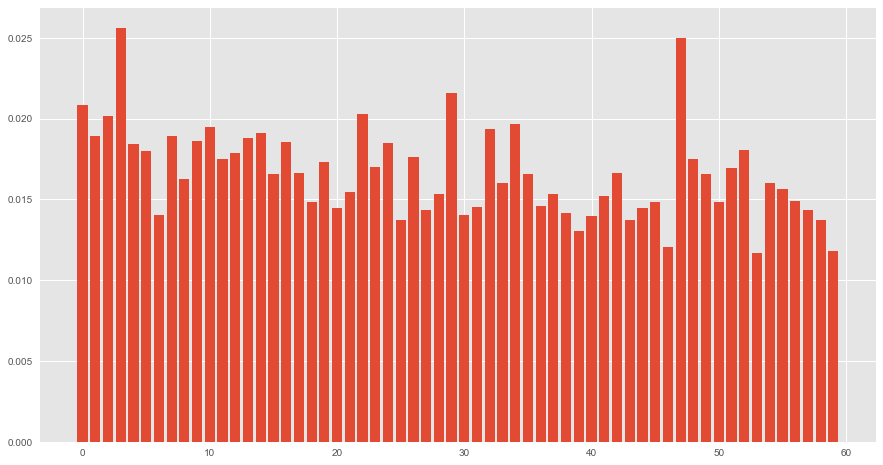

In [1534]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=1)
model.fit(X=X_train, y=y_train)
score = model.score(X=X_validation, y=y_validation)
print("Prediction:\n", model.predict(X=X_validation))
print("Reality:\n", games_latent_df[:test_set_size][['y']].values.ravel())
print("Score (mean accuracy):", score)
plt.bar(left=np.arange(0, len(labels[2:]), 1), height=model.feature_importances_)

#### Gradient Boosting Classifier

Prediction:
 [ 1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1  0  1  1  0  1  1  1 -1  1  1  0
  1  1 -1 -1  1 -1 -1 -1  0  0  0 -1  1  1  1  1  1  0 -1 -1  1 -1  1  1  1
  0 -1  1  1  1 -1  0  0 -1  0  1 -1  1  0  0  1 -1  0  0  0 -1  1  1  1  1
  1  1  1  1  1  1  1  0  1 -1  1 -1  1  1  1  0  0  1  1  1  1  1  1  0  0
  1 -1 -1 -1 -1  1 -1  1  0 -1  1  1 -1  1  1  1  1  0  1  1  1  1 -1 -1  1
  1 -1  1  1  1  0 -1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  0
  1  0  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1  1  0 -1  1 -1  0  1 -1  0  1
  0 -1 -1  1  0  1 -1  1  1  0 -1  0  1  1  0  1  1  1  0  1 -1  1 -1  1  1
  1]
Reality:
 [-1  1  0 -1 -1  0  1  0 -1 -1 -1  0  1  0  0  0  1 -1  0  1  0  0  1 -1  0
  0  1 -1  1  0  1 -1  1 -1  0  1  1 -1  1  1 -1 -1 -1  0  1 -1  0  0  1  1
  1  1  0  1  1  0  0  0  1  0  0  0  0 -1  1  1  0 -1  1  1  0  1 -1  1  0
  0 -1  0  1  0  0  0  0  1  1  0  0  1  0  1  1  0  1 -1  1  0 -1 -1  1  1
  0  0  1  1  0 -1  1 -1  1  1  1  1 -1  1 -1  1  1  0  1  0

<Container object of 60 artists>

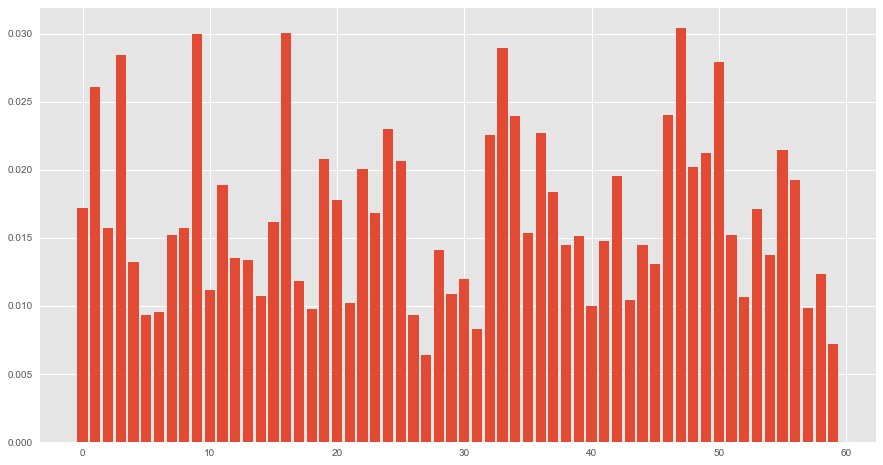

In [1535]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=200, random_state=1)
model.fit(X=X_train, y=y_train)
score = model.score(X=X_validation, y=y_validation)
print("Prediction:\n", model.predict(X=X_validation))
print("Reality:\n", games_latent_df[:test_set_size][['y']].values.ravel())
print("Score (mean accuracy):", score)
plt.bar(left=np.arange(0, len(labels[2:]), 1), height=model.feature_importances_)

## A look at the events

In [112]:
events_df = pd.read_csv(EVENTS_FILE)
events_df.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [113]:
events_with_goals_df = events_df.copy()
events_with_goals_df.loc[(events_with_goals_df['event_type'] == 1) & (events_with_goals_df['text'].str.startswith('Goal')), 'event_type'] = 0


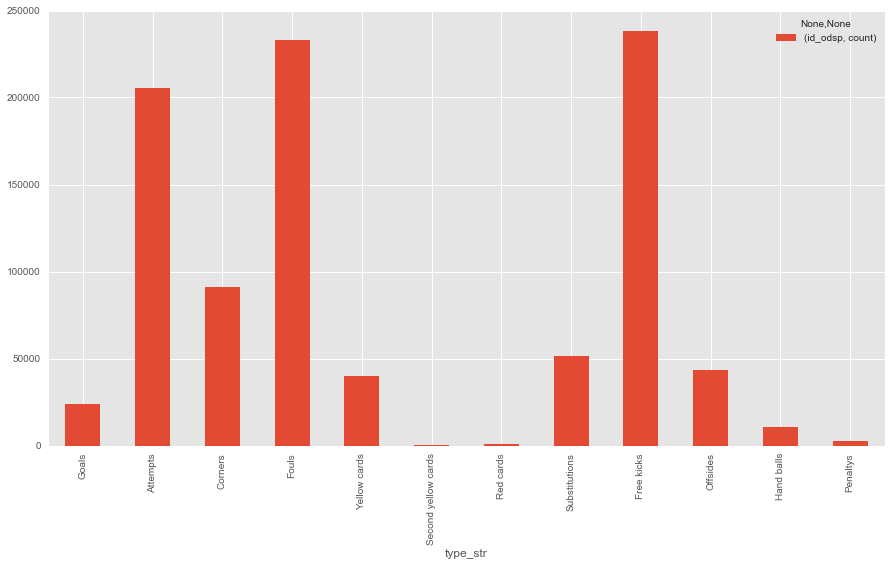

In [114]:
events = ['Goals', 'Attempts', 'Corners', 'Fouls', 'Yellow cards', 'Second yellow cards', 'Red cards', 'Substitutions', 'Free kicks', 'Offsides', 'Hand balls', 'Penaltys']
event_types_df = events_with_goals_df[['id_odsp', 'event_type']].groupby(['event_type']).agg(['count'])
event_types_df['type_str'] = events
event_types_df.plot(kind='bar', x='type_str')

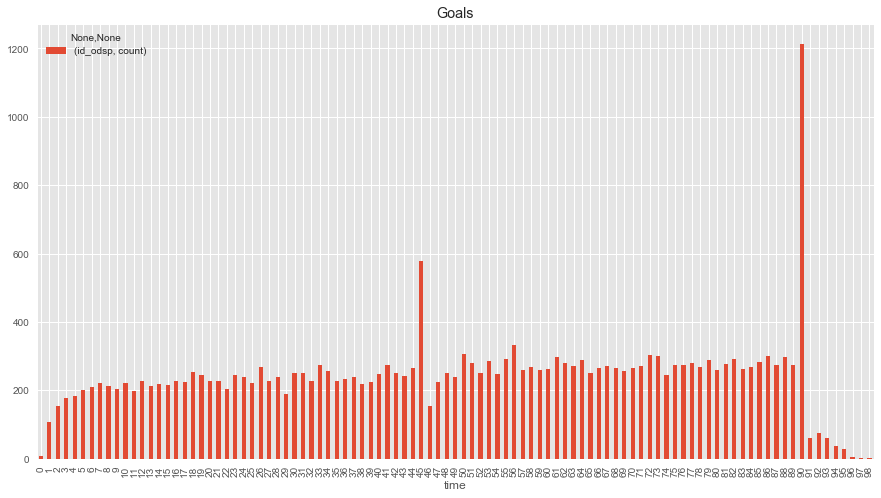

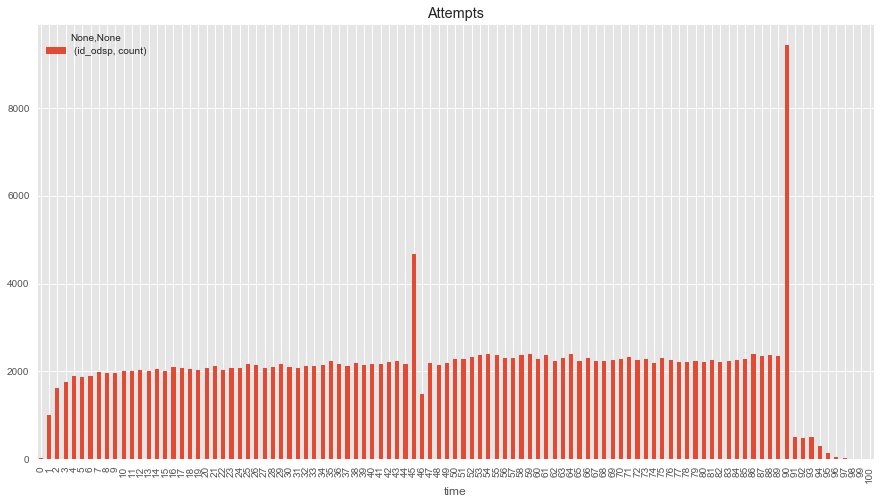

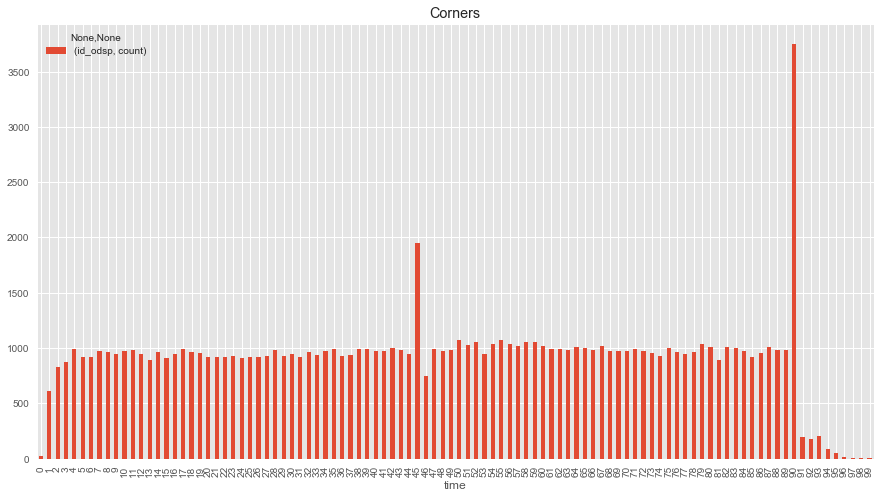

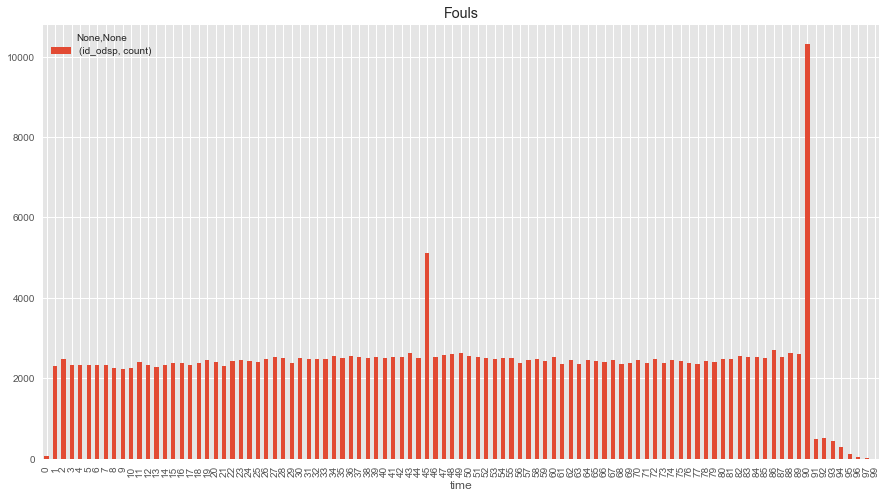

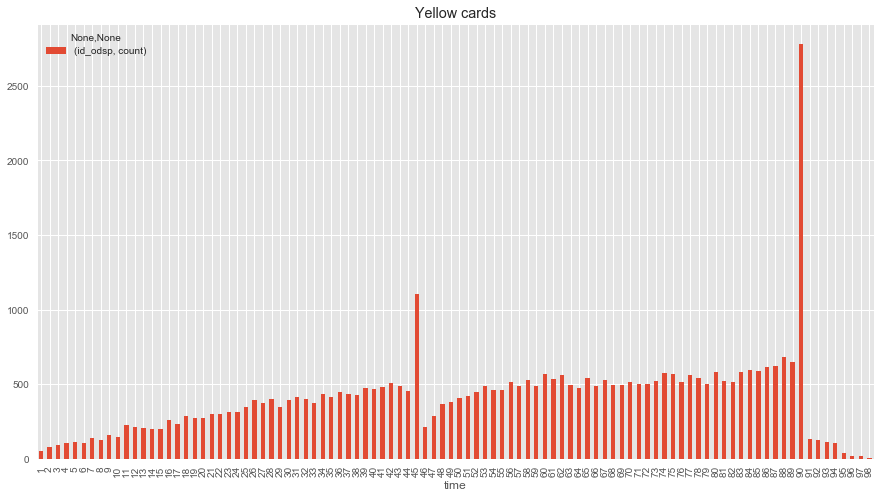

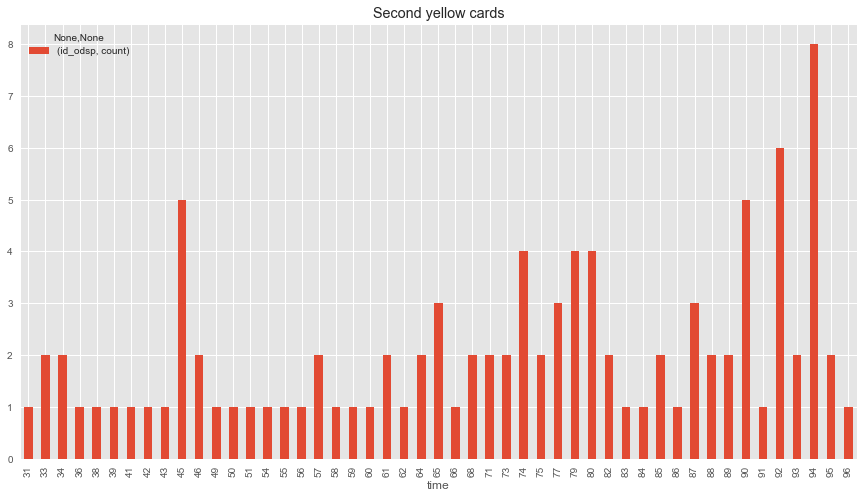

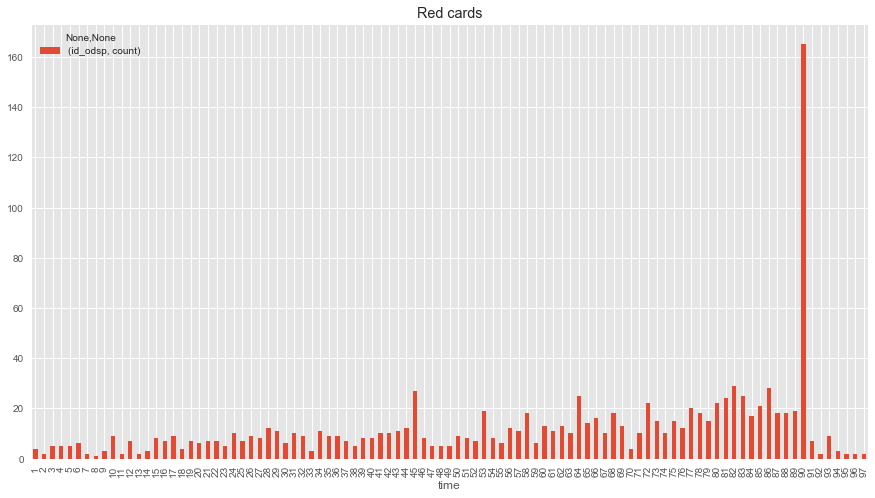

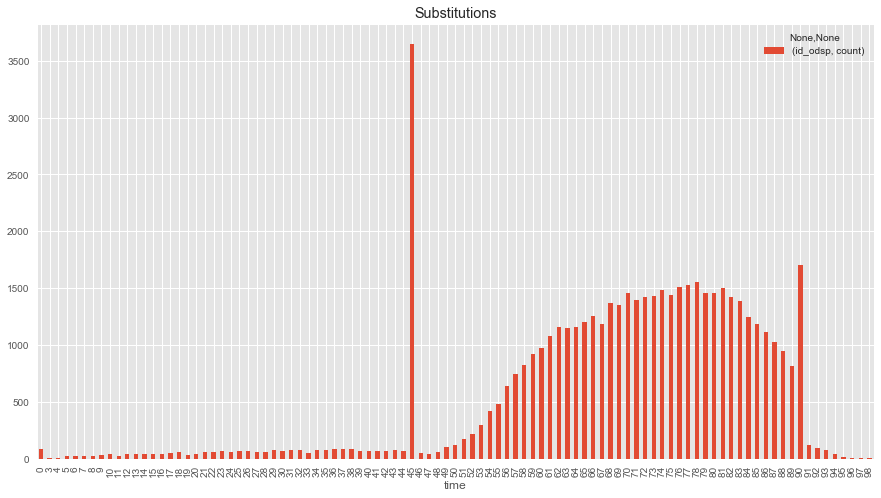

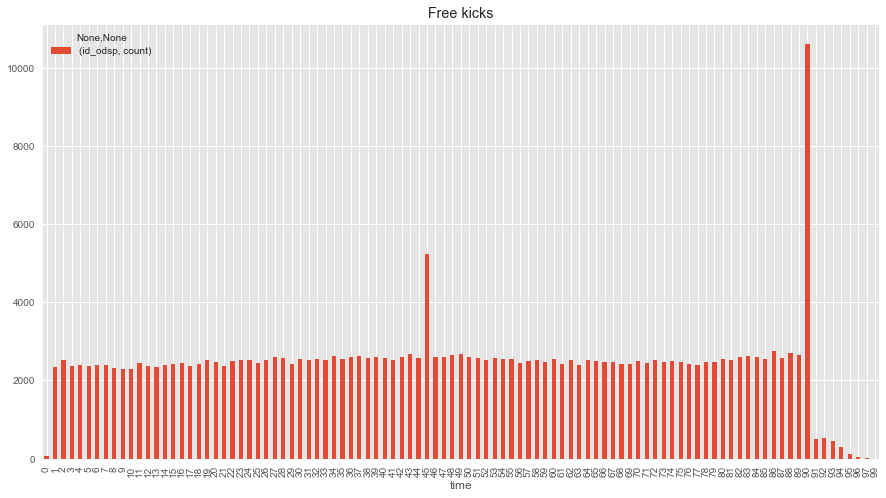

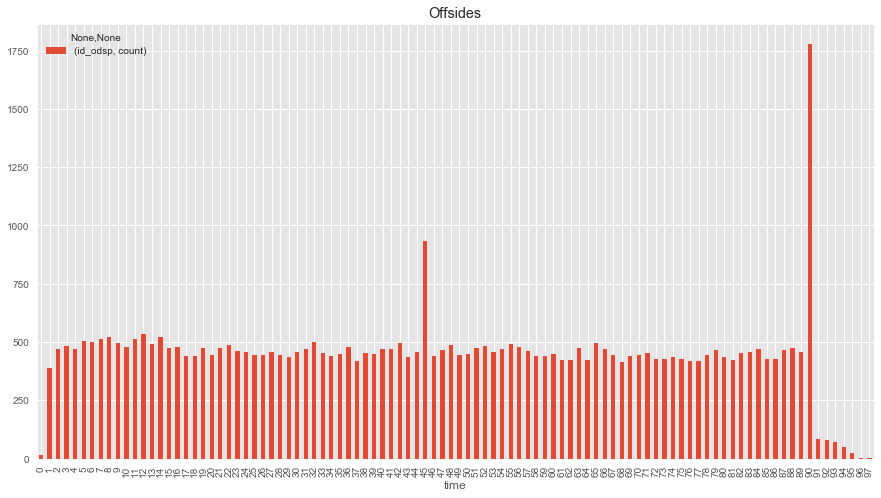

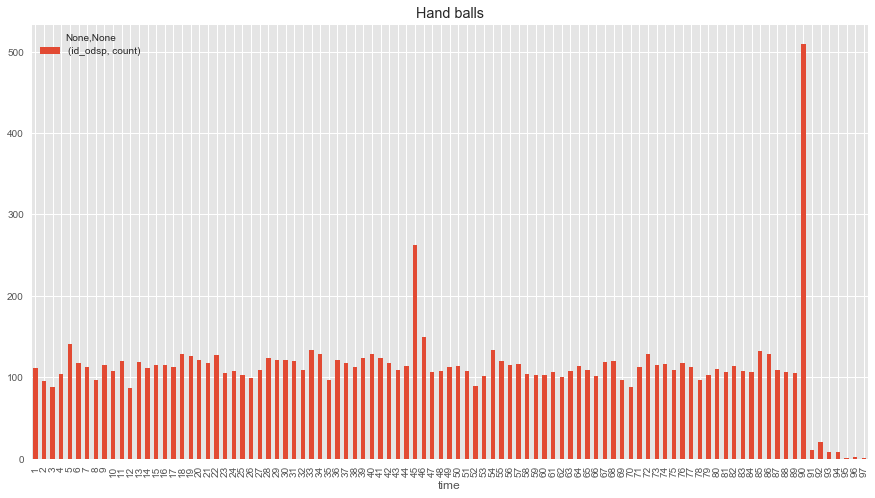

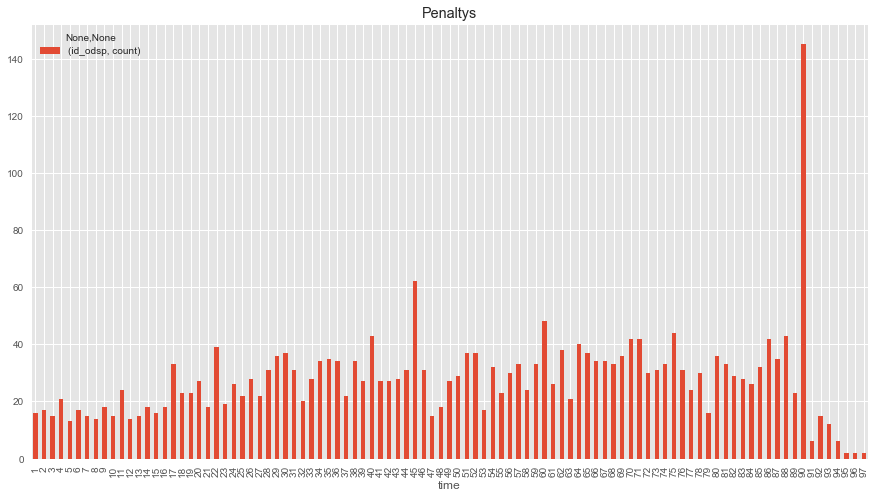

In [115]:
for i in range(len(events)):
    events_with_goals_df[events_with_goals_df['event_type'] == i][['id_odsp', 'time']].groupby(['time']).agg(['count']).plot(title=events[i], kind='bar')
